# English - Alice in wonderland

## Data preparation

In [1]:
from importlib import reload

In [2]:
import preprocessor
preprocessor = reload(preprocessor)


pp = preprocessor.Preprocessor("data/original/bengali_corpus.txt", "bng")
cleaned_corpus = pp.process()
pp.split(cleaned_corpus)

10861 2716


## Subword segmentation

In [3]:
import sentpiece
sentpiece = reload(sentpiece)

In [5]:
# character-level
TRAIN_DATA_PATH = "data/processed/bng_train.txt"
TEST_DATA_PATH = "data/processed/bng_test.txt"
models, test_models = [], []
seg_train_path, seg_test_path = [], []
start=50
stop=100
step=50

for vocab_size in range(start, stop, step):
    MODEL_NAME = "bng_train_"+str(vocab_size)
    SEG_DATA_PATH = f"bng_tr_chr_{str(vocab_size)}.txt"
    sentpiece.train_model(TRAIN_DATA_PATH, MODEL_NAME, vocab_size, lang="bng")
    models.append(MODEL_NAME)
    seg_train_path.append(SEG_DATA_PATH)
    
for vocab_size in range(start, stop, step):
    MODEL_NAME = "bng_test_"+str(vocab_size)
    SEG_DATA_PATH = f"bng_te_chr_{str(vocab_size)}.txt"
    sentpiece.train_model(TEST_DATA_PATH, MODEL_NAME, vocab_size, lang="bng")
    test_models.append(MODEL_NAME)
    seg_test_path.append(SEG_DATA_PATH)

In [4]:
import shutil, glob, os

for model in models+test_models:
    for file in glob.glob(f'{model}*'):
        cwd = os.getcwd() 
        src = cwd
        dst = cwd + "/spm_models/"
        shutil.move(os.path.join(src, file), os.path.join(dst, file))

In [6]:
for model, seg_path in zip(models,seg_train_path):
    sentpiece.segmentation(TRAIN_DATA_PATH, model, seg_path)

for model, seg_path in zip(test_models,seg_test_path):
    sentpiece.segmentation(TEST_DATA_PATH, model, seg_path)

## Train LM

In [7]:
for model, seg_path in zip(models,seg_train_path):
    print(seg_path)

bng_tr_chr_50.txt


In [ ]:
import subprocess

NUM_LAYERS = [60,70]
CLASS = [50,6000,7000,8000,9000,9999]
BPTT = [3,4]

dir_path="data/segmented/"

for train_file, test_file in zip(seg_train_path, seg_test_path):
    for hid in NUM_LAYERS:
        for cl in CLASS:
            for bp in BPTT:
                fname="hd"+str(hid)+"_cl"+str(cl)+"_"+str(bp)+"_"+train_file[train_file.rfind("/")+1:train_file.rfind('.')]
                print(fname)
                args = ['bash', 'train_script.sh', dir_path+train_file, dir_path+test_file, fname, str(hid), str(cl), str(bp)]
                p = subprocess.run(args)
                print(p)


hd60_cl50_3_bng_tr_chr_50
CompletedProcess(args=['bash', 'train_script.sh', 'data/segmented/bng_tr_chr_50.txt', 'data/segmented/bng_te_chr_50.txt', 'hd60_cl50_3_bng_tr_chr_50', '60', '50', '3'], returncode=0)
hd60_cl50_4_bng_tr_chr_50
CompletedProcess(args=['bash', 'train_script.sh', 'data/segmented/bng_tr_chr_50.txt', 'data/segmented/bng_te_chr_50.txt', 'hd60_cl50_4_bng_tr_chr_50', '60', '50', '4'], returncode=0)
hd60_cl6000_3_bng_tr_chr_50


## Data generation

In [7]:
GEN_DATA_PATH = "data/generated/hd70_cl6000_3_bng_tr_chr_50/"
MODEL_PATH = f"./rnnlm_models/hd70_cl6000_3_bng_tr_chr_50"

from pathlib import Path
Path(GEN_DATA_PATH).mkdir(parents=True, exist_ok=True)

!bash gen_script.sh $GEN_DATA_PATH $MODEL_PATH

In [11]:
# Decoding generated texts

sentpiece.desegmentation("data/generated/hd70_cl6000_3_bng_tr_chr_50/100.txt", "bng_train_50")

# OOV comparison

In [15]:
from collections import Counter

def get_vocab(path):
    vocab=[]
    with open(path) as f:
        data = f.read()
        vocab = Counter(data.split())
        return vocab

TRAIN_DATA_PATH = "data/processed/bng_train.txt"
TEST_DATA_PATH = "data/processed/bng_test.txt"
train_vocab = get_vocab(TRAIN_DATA_PATH)
test_vocab = get_vocab(TEST_DATA_PATH)
print(len(train_vocab), len(test_vocab))

40172 12050


In [16]:
def compute_oov_rate(train_vocab, test_vocab):
    oov_words = list(test_vocab.keys()-train_vocab.keys())
    count_oov = 0
    for k, v in test_vocab.items():
        if k in oov_words:
            count_oov += v
            
    oov_rate = count_oov / sum(test_vocab.values())
    return oov_rate

compute_oov_rate(train_vocab, test_vocab)

0.13434656741108353

In [17]:
def augment_vocab(train_vocab, add_vocab):
    #print(len(train_vocab))
    for k, v in add_vocab.items():
        if k not in train_vocab:
            train_vocab.update({k:v})
        else:
            train_vocab.update({k:train_vocab[k]+v})
    #print(len(train_vocab))
    return train_vocab

In [18]:
# char-level baselines 
dir_path="data/generated/bng_chr_50/"
oov_rates = {}
for i in range(1,8):
    file=10**i
    print(file)
    #sentpiece.desegmentation(dir_path+str(file)+".txt", "bng_train_50")
    add_vocab=get_vocab(dir_path+str(file)+"_desegmented.txt")
    oov_rates[file] = compute_oov_rate(augment_vocab(train_vocab, add_vocab), test_vocab)
print(oov_rates)

10
100
1000
10000
100000
1000000
10000000
{10: 0.13434656741108353, 100: 0.13434656741108353, 1000: 0.13434656741108353, 10000: 0.13409842845326717, 100000: 0.1326095947063689, 1000000: 0.1272125723738627, 10000000: 0.1153225806451613}


No handles with labels found to put in legend.


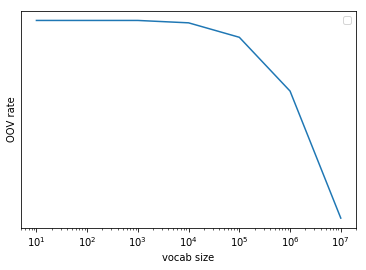

In [10]:
import matplotlib.pyplot as plt

def plot_oov_rates(oov_rates) -> None:
    fig, ax = plt.subplots()
    plt.loglog(list(oov_rates.keys()), list(oov_rates.values()))
    ax.set_xlabel("vocab size")
    ax.set_ylabel("OOV rate")
    plt.legend()
    plt.show()

plot_oov_rates(oov_rates)

# Bengali

In [29]:
TRAIN_DATA_PATH = "data/processed/bng_train.txt"
models = []
seg_data_path = []

for vocab_size in range(1500, 3250, 250):
    #NUM_CHARS = 113
    TRAIN_DATA_PATH = "data/processed/bng_train.txt"
    MODEL_NAME = "bng_wd_model_"+str(vocab_size)
    SEG_DATA_PATH = f"bng_wd_{str(vocab_size)}.txt"
    sentpiece.train_model(TRAIN_DATA_PATH, MODEL_NAME, vocab_size, lang="bng")
    models.append(MODEL_NAME)
    seg_data_path.append(SEG_DATA_PATH)

In [30]:
import shutil, glob, os

for model in models:
    for file in glob.glob(f'{model}*'):
        cwd = os.getcwd() 
        src = cwd
        dst = cwd + "/spm_models/"
        shutil.move(os.path.join(src, file), os.path.join(dst, file))

In [31]:
TRAIN_DATA_PATH = "data/processed/bng_train.txt"
for model, seg_path in zip(models,seg_data_path):
    sentpiece.segmentation(TRAIN_DATA_PATH, model, seg_path)

In [ ]:
import subprocess

NUM_LAYERS = 40
CLASS = 9999
BPTT = 3



#for filename in data/segmented/bng_chr_*.txt; do


for train_seg_file in glob.glob("data/segmented/*.txt"):
    if train_seg_file.startswith("data/segmented/bng_wd_"):
        print(train_seg_file)
        args = ['bash', 'train_script.sh', train_seg_file, 'data/processed/bng_test.txt', train_seg_file[15:26], str(NUM_LAYERS), str(CLASS), str(BPTT)]
        p = subprocess.run(args)
        print(p)

        #TRAIN_SEG_DATA_PATH = "data/segmented/bng_chr.txt"
        #script_args = f"{train_seg_file} data/processed/bng_test.txt {train_seg_file[15:26]} {str(NUM_LAYERS)} {str(CLASS)} {str(BPTT)}"
                      #str(NUM_LAYERS), "-rand-seed", "1", "-debug", "2", "-class", str(CLASS), "-bptt", str(BPTT)]
        #subprocess.Popen(["bash", './train_script.sh', str(train_seg_file), "data/processed/bng_test.txt", str(train_seg_file[15:26]), str(NUM_LAYERS), str(CLASS), str(BPTT)], shell=True) #+ [f"{train_seg_file} data/processed/bng_test.txt {str(NUM_LAYERS)} {str(CLASS)} {str(BPTT)}"])

#for fname in 
#!bash train_script.sh  "data/processed/bng_test.txt" $NUM_LAYERS $CLASS $BPTT

data/segmented/bng_wd_1500.txt
CompletedProcess(args=['bash', 'train_script.sh', 'data/segmented/bng_wd_1500.txt', 'data/processed/bng_test.txt', 'bng_wd_1500', '40', '9999', '3'], returncode=0)
data/segmented/bng_wd_1750.txt
CompletedProcess(args=['bash', 'train_script.sh', 'data/segmented/bng_wd_1750.txt', 'data/processed/bng_test.txt', 'bng_wd_1750', '40', '9999', '3'], returncode=0)
data/segmented/bng_wd_2000.txt


In [20]:
import shlex, subprocess
cmdl = input()

bash train_script.sh data/segmented/bng_wd_1500.txt data/processed/bng_test.txt bng_wd_1500 "echo '$NUM_LAYERS'" "echo '$CLASS'" "echo '$BPTT'"


In [21]:
args = shlex.split(cmdl)
print(args)

['bash', 'train_script.sh', 'data/segmented/bng_wd_1500.txt', 'data/processed/bng_test.txt', 'bng_wd_1500', "echo '$NUM_LAYERS'", "echo '$CLASS'", "echo '$BPTT'"]


# Analysis